In [1]:
import numpy as np
import jax.numpy as jnp

import os
import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *

In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/Koch_Meinhardt_2.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())

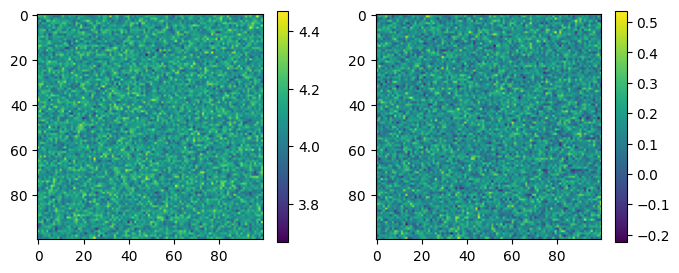

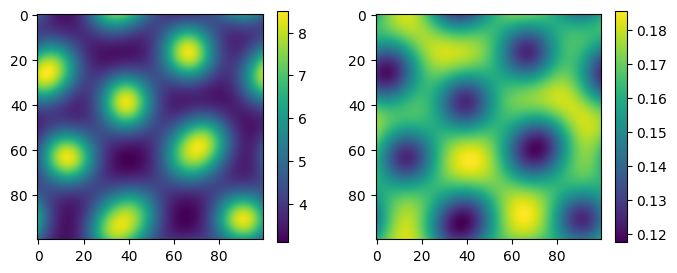

In [3]:
t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)


T = t_star.shape[0]    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

In [4]:
dxdy = x_size*y_size/L**2
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [5]:
t_star = t_star[-2:]
data = data[..., -2:]
c_xx = c_xx[..., -2:]
c_yy = c_yy[..., -2:]
c_t = c_t[..., -2:]
T = t_star.shape[0]  

In [6]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
#indices_sub = indices_all[:, 30:65, 50:85]
indices_sub = indices_all[:, 30:65:10, 50:85:10]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': None,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']
obs_outputs = dataset['obs_output']
der_u_outputs = dataset["der_u"].T
der_v_outputs = dataset["der_v"].T
obs_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)
pde_X = obs_inputs

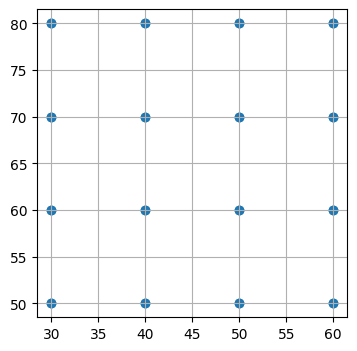

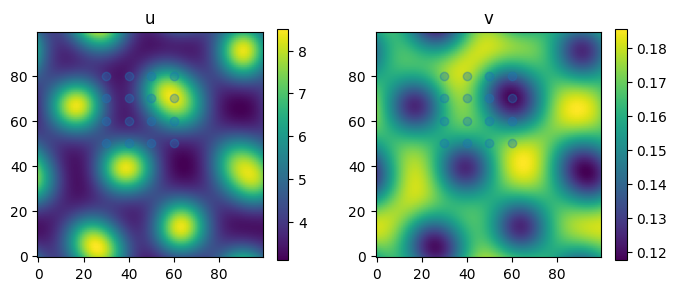

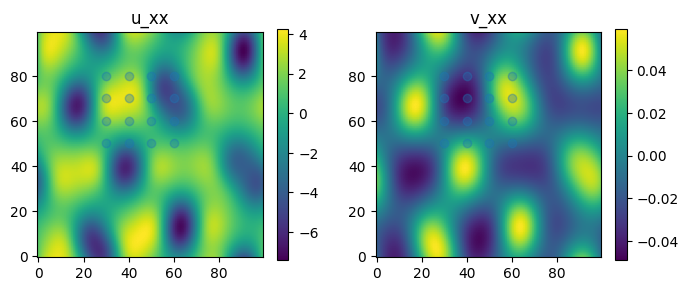

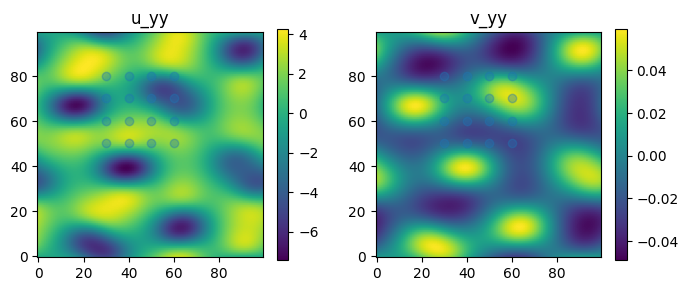

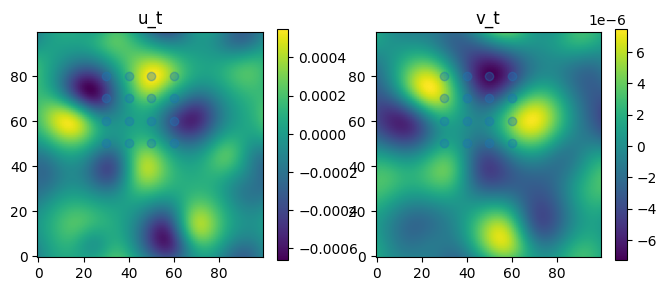

In [7]:
_ = plt.figure(figsize=(4,4))
plt.scatter((x_size-1)*obs_X[:,0]/L, (x_size-1)*obs_X[:,1]/L)
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is changing in the outer arrays. So, we must transpose them on
##                ploting time
def plot_domain(d, title_1="u", title_2="v"):
    _ = plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.title(f"{title_1}")
    plt.imshow(d[0,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.2)
    plt.subplot(122)
    plt.title(f"{title_2}")
    plt.imshow(d[1,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.2)    
    plt.show()

plot_domain(data, title_1="u", title_2="v")
plot_domain(c_xx, title_1="u_xx", title_2="v_xx")
plot_domain(c_yy, title_1="u_yy", title_2="v_yy")
plot_domain(c_t, title_1="u_t", title_2="v_t")

In [8]:
def diff_u():
    D_u = simulation.Ds[0] 
    u_xx = der_u_outputs[:, 0]
    u_yy = der_u_outputs[:, 1]
    return D_u * (u_xx + u_yy)

def diff_v():
    D_v = simulation.Ds[1]
    v_xx = der_v_outputs[:, 0]
    v_yy = der_v_outputs[:, 1]
    D_v * (v_xx + v_yy)
    
def interaction_u(kappa_u, rho_u):
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    f = u * u * v / (1.0 + kappa_u * u * u)
    return rho_u * f

def interaction_v(kappa_u, rho_v):
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    f = u * u * v / (1.0 + kappa_u * u * u)
    return -rho_v * f

def pde_res_u(kappa_u, rho_u, mu_u, sigma_u):
    D_u = simulation.Ds[0] 
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    u_xx = der_u_outputs[:, 0]
    u_yy = der_u_outputs[:, 1]
    u_t = der_u_outputs[:, 2]    
    f = u * u * v / (1.0 + kappa_u * u * u)
    return u_t - D_u * (u_xx + u_yy) - rho_u * f + mu_u * u - sigma_u

def pde_res_v(kappa_u, rho_v, sigma_v):
    D_v = simulation.Ds[1]
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    v_xx = der_v_outputs[:, 0]
    v_yy = der_v_outputs[:, 1]
    v_t = der_v_outputs[:, 2]    
    f = u * u * v / (1.0 + kappa_u * u * u)
    return v_t - D_v * (v_xx + v_yy) + rho_v * f - sigma_v

def create_fast_pde_res_u(kappa_u):    
    D_u = simulation.Ds[0] 
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    u_xx = der_u_outputs[:, 0]
    u_yy = der_u_outputs[:, 1]
    u_t = der_u_outputs[:, 2]
    f = u * u * v / (1.0 + kappa_u * u * u)
    s = u_t - D_u * (u_xx + u_yy)
    def pde_res_u(rho_u, mu_u, sigma_u):
        return s - rho_u * f + mu_u * u - sigma_u
    return pde_res_u
    
def create_fast_pde_res_v(kappa_u):
    D_v = simulation.Ds[1] 
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    v_xx = der_v_outputs[:, 0]
    v_yy = der_v_outputs[:, 1]
    v_t = der_v_outputs[:, 2] 
    f = u * u * v / (1.0 + kappa_u * u * u)
    s = v_t - D_v * (v_xx + v_yy)
    def pde_res_v(rho_v, sigma_v):
        return s + rho_v * f - sigma_v
    return pde_res_v
    

def L2_mean(x):
    return np.mean(x**2)

def root_L2_mean(x):
    return np.sqrt(L2_mean(x))

In [9]:
res_u = create_fast_pde_res_u(simulation.parameters['kappa_u'])
res_v = create_fast_pde_res_v(simulation.parameters['kappa_u'])

In [10]:

print(root_L2_mean(
    res_u(simulation.parameters['rho_u'],
          simulation.parameters['mu_u'],
          simulation.parameters['sigma_u'],)
))

print(root_L2_mean(
    res_v(simulation.parameters['rho_v'],
          simulation.parameters['sigma_v'],)
))

1.9116287445683686e-06
2.525774000342432e-08


In [151]:
kappa_u_r = np.concatenate([[-1, -.5 ], np.linspace(0, 2, 21)]) #n

size = 40

rho_u_r = np.linspace(-2, 2, size+1)
rho_v_r = np.linspace(-2, 2, size+1)
sigma_u_r = np.linspace(-2, 2, size+1)
sigma_v_r = np.linspace(-2, 2, size+1)
mu_u_r = np.linspace(-2, 2, size+1)

rho_u_d, mu_u_d, sigma_u_d, kappa_u_1_d = np.meshgrid(rho_u_r, mu_u_r, sigma_u_r, kappa_u_r, indexing='ij')
rho_v_d, sigma_v_d, kappa_u_2_d = np.meshgrid(rho_v_r, sigma_v_r, kappa_u_r,  indexing='ij')

In [152]:
mu_u_r

array([-2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. ,
       -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,
        0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,
        1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ])

In [13]:
kappa_u_r.shape

(23,)

In [103]:
rho_v_r.shape

(41,)

In [15]:
kappa_u_1_d.shape

(41, 42, 43, 23)

In [16]:
rho_u_d.shape

(41, 42, 43, 23)

In [153]:
res_u_per_kappa = [create_fast_pde_res_u(k) for k in kappa_u_r]

In [154]:
res_v_per_kappa = [create_fast_pde_res_v(k) for k in kappa_u_r]

In [155]:
u_landscape = np.array([[[[root_L2_mean(f1(r, m , s)) 
               for f1 in res_u_per_kappa]
               for s in sigma_u_r]
               for m in mu_u_r]
               for r in rho_u_r])

In [156]:
u_landscape.shape

(41, 41, 41, 23)

In [157]:
sigma_u_r.shape

(41,)

In [158]:
v_landscape = np.array([[[root_L2_mean(f1(r, s)) 
               for f1 in res_v_per_kappa]
               for s in sigma_v_r]
               for r in rho_v_r])

In [159]:
v_landscape.shape

(41, 41, 23)

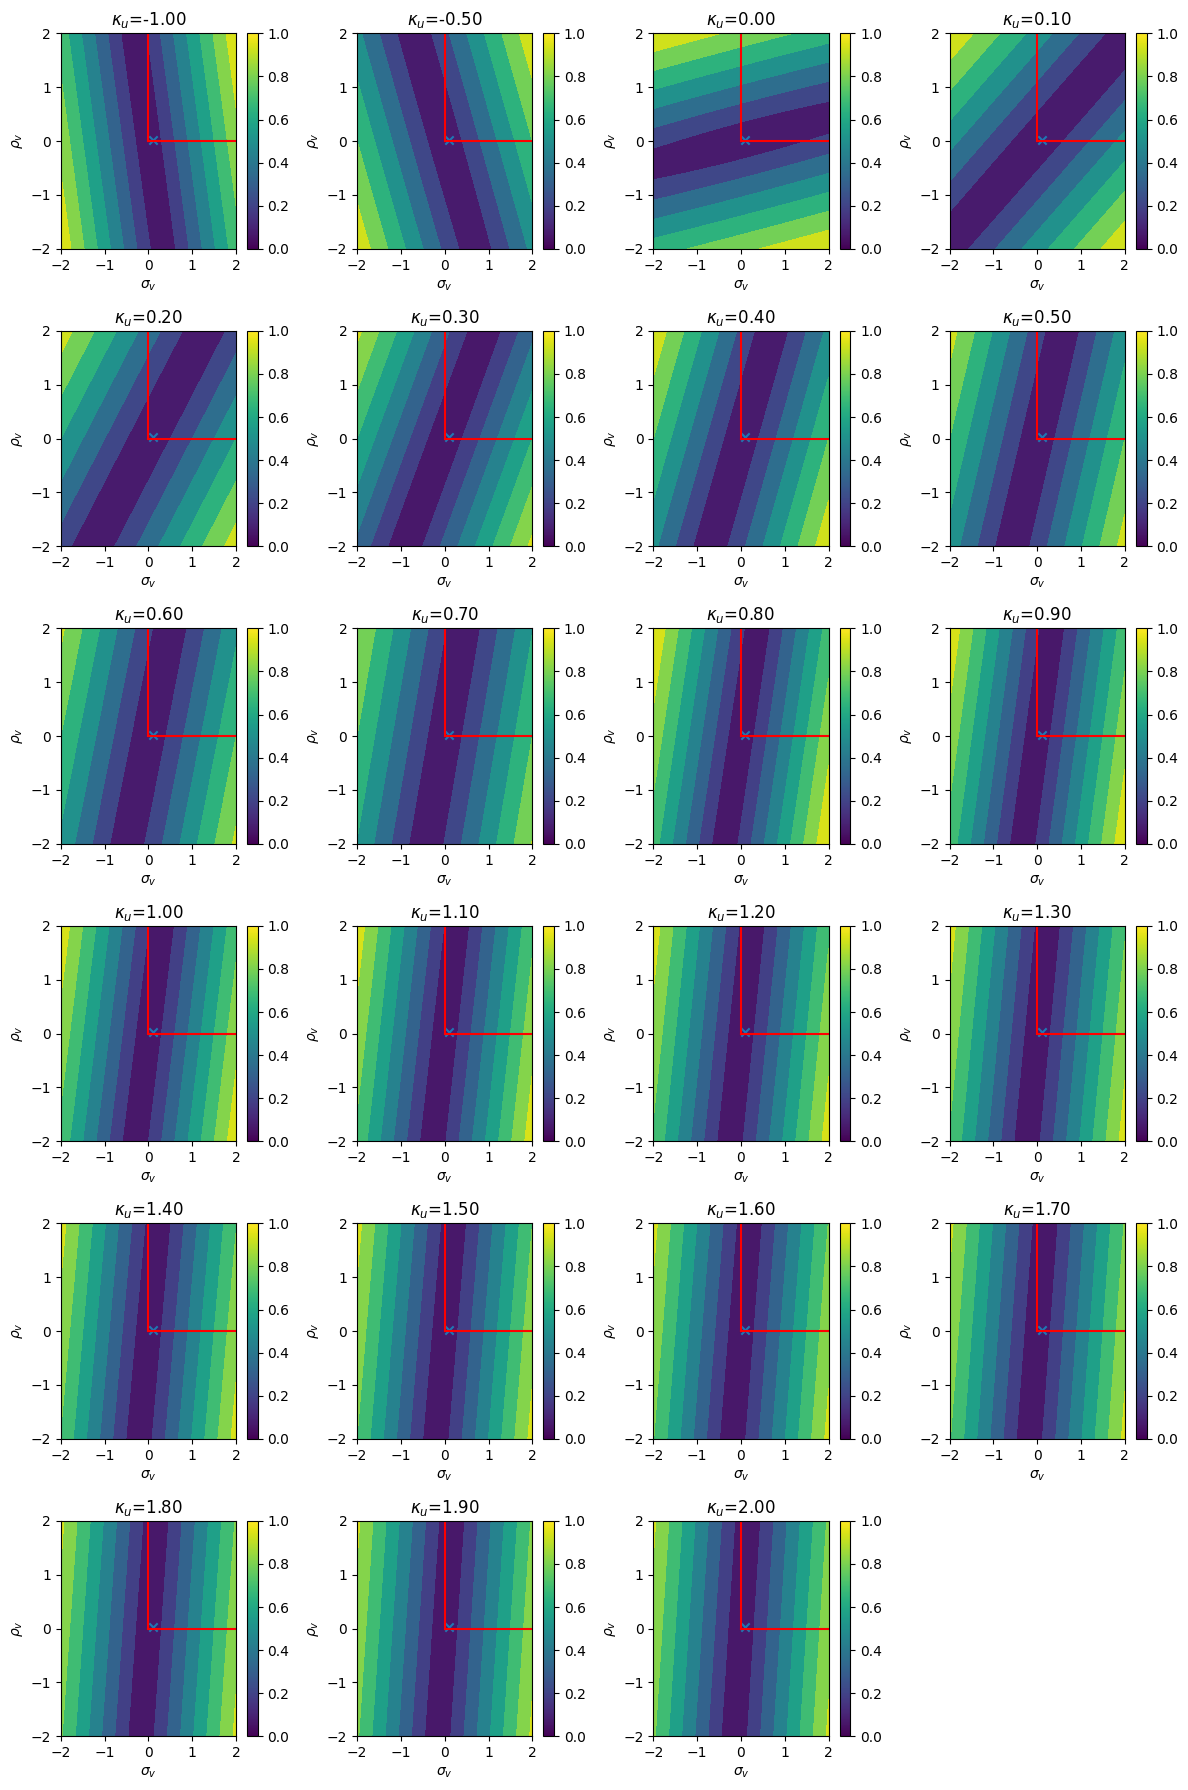

In [160]:
_ = plt.figure(figsize=(12,18))

for i in range(6):
    for j in range(4):
        if j + i*4 >= kappa_u_r.shape[0]:
            break
        plt.subplot(6, 4, 1+ j + i*4)
        plt.title(r"$\kappa_u$" f"={kappa_u_r[j + i*4]:.2f}")
        plt.contourf(rho_v_r, sigma_v_r,  v_landscape[..., j + i*4])
        plt.plot([0, sigma_v_r[-1]], [0, 0], c='r')
        plt.plot([0, 0], [0, rho_v_r[-1]], c='r')
        plt.scatter(simulation.parameters['sigma_v'], simulation.parameters['rho_v'], marker='x')
        plt.xlabel(r"$\sigma_v$")
        plt.ylabel(r"$\rho_v$")
        plt.colorbar()
plt.tight_layout()
plt.show()

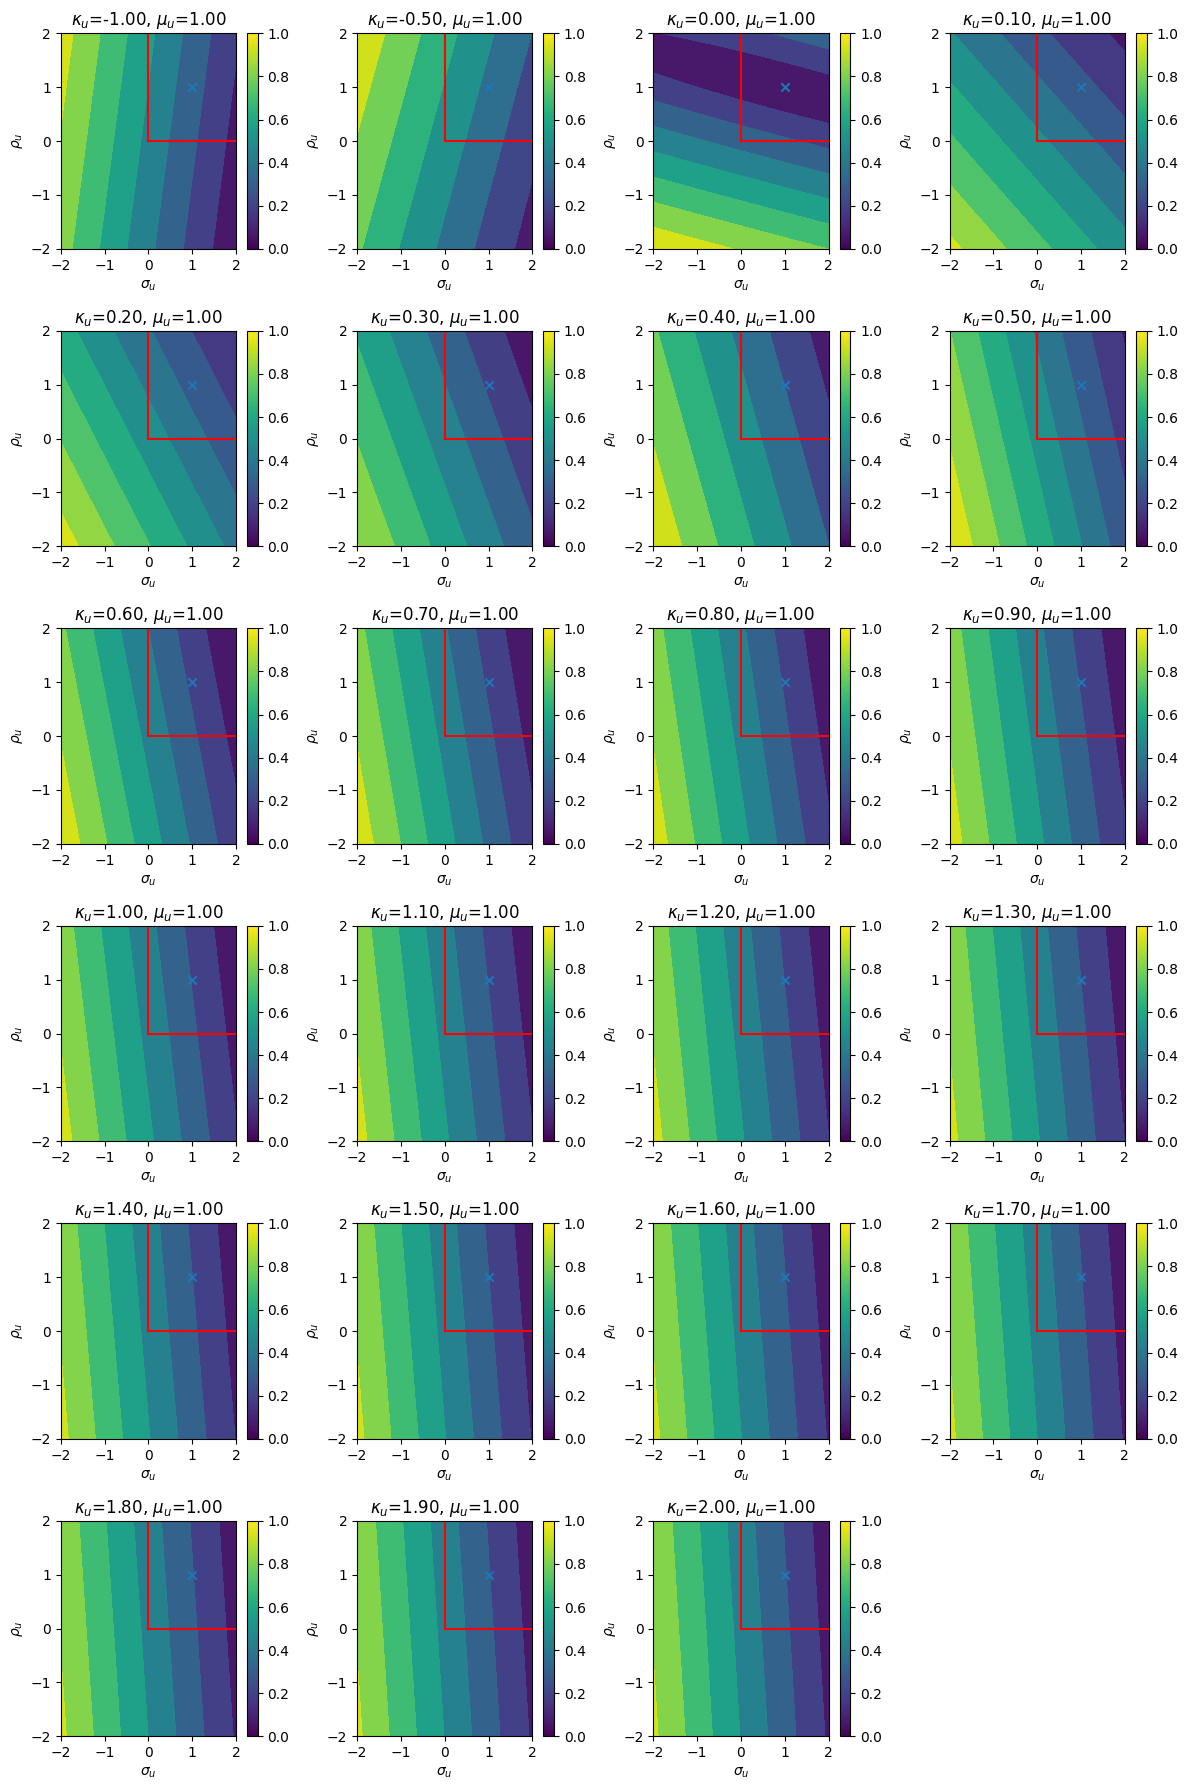

In [161]:
_ = plt.figure(figsize=(12,18))
mu_u_index = 30
for i in range(6):
    for j in range(4):
        if j + i*4 >= kappa_u_r.shape[0]:
            break
        plt.subplot(6, 4, 1+ j + i*4)
        plt.title(r"$\kappa_u$" f"={kappa_u_r[j + i*4]:.2f}, "
                  r"$\mu_u$" f"={mu_u_r[mu_u_index]:.2f}")
        plt.contourf(sigma_u_r, rho_u_r, u_landscape[:, mu_u_index, :, j + i*4])
        plt.plot([0, sigma_u_r[-1]], [0, 0], c='r')
        plt.plot([0, 0], [0, rho_u_r[-1]], c='r')
        plt.scatter(simulation.parameters['sigma_u'], simulation.parameters['rho_u'], marker='x')
        plt.xlabel(r"$\sigma_u$")
        plt.ylabel(r"$\rho_u$")
        plt.colorbar()
plt.tight_layout()
plt.show()

In [162]:
simulation.parameters

{'kappa_u': 0.0,
 'mu_u': 1.0,
 'rho_u': 1.0,
 'rho_v': 0.025,
 'sigma_u': 1.0,
 'sigma_v': 0.1}

In [163]:
u_landscape.shape

(41, 41, 41, 23)

In [164]:
find_index(mu_u_r, 1.21, atol=1e-2)

32

In [165]:
def find_index(arr, value, atol=1e-2):
    return np.argwhere(np.isclose(arr, value, atol=atol) )[0][0]

def find_exact(arr, value, atol=1e-2):
    index = find_index(arr, value, atol)
    return arr[index]

def plot_1(kappa_u, mu_u):
    kappa_u = float(kappa_u)
    mu_u = float(mu_u)
    plt.title(r"$\kappa_u$" f"={kappa_u:.2f}, " r"$\mu_u$" f"={mu_u:.2f}")
    kappa_u_index = find_index(kappa_u_r,kappa_u, atol=1e-2)
    mu_u_index = find_index(mu_u_r, mu_u, atol=1e-2) 
    plt.contourf(sigma_u_r, rho_u_r, u_landscape[:, mu_u_index ,:, kappa_u_index])
    plt.plot([0, sigma_u_r[-1]], [0, 0], c='r')
    plt.plot([0, 0], [0, rho_u_r[-1]], c='r')
    plt.scatter(simulation.parameters['sigma_u'], simulation.parameters['rho_u'], marker='x')
    plt.xlabel(r"$\sigma_u$")
    plt.ylabel(r"$\rho_u$")
    plt.colorbar()
    


In [168]:
find_index(mu_u_r, simulation.parameters['mu_u'], 1e-2)

30

In [169]:
from ipywidgets import interact, Layout#, DescriptionStyle
import ipywidgets as widgets
from IPython.display import display

kappa_u_widgets= widgets.SelectionSlider(
    options= [f"{v:.2f}" for v in kappa_u_r], # kappa_u_r,
    value=f"{simulation.parameters['kappa_u']:.2f}",
    description=r'$\kappa_u$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    #style={'font_size':40, 'font-weight': 'bold'},
    #font_size=40,
)

mu_u_widgets= widgets.SelectionSlider(
    options= [f"{v:.2f}" for v in mu_u_r], # kappa_u_r,
    value=f"{find_exact(mu_u_r, simulation.parameters['mu_u']):.2f}",
    description=r'$\mu_u$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    #style={'font_size':40, 'font-weight': 'bold'},
    #font_size=40,
)

#display(kappa_u_widgets)
#display(mu_u_widgets)
actuals_widgets = widgets.HBox([widgets.Label(value=r'$\kappa_u$ = 'f"{simulation.parameters['kappa_u']:.2f}"), 
                                widgets.Label(value=r'$\mu_u$ = 'f"{simulation.parameters['mu_u']:.2f}"),
                                widgets.Label(value=r'$\rho_u$ = 'f"{simulation.parameters['rho_u']:.2f}"),
                                widgets.Label(value=r'$\sigma_u$ = 'f"{simulation.parameters['sigma_u']:.2f}"),])
display(actuals_widgets)
interact(plot_1, kappa_u=kappa_u_widgets, mu_u=mu_u_widgets)

interactive(children=(SelectionSlider(continuous_update=False, description='$\\kappa_u$', index=2, options=('-…

<function __main__.plot_1(kappa_u, mu_u)>

In [129]:
simulation.parameters

{'kappa_u': 0.0,
 'mu_u': 1.0,
 'rho_u': 1.0,
 'rho_v': 0.025,
 'sigma_u': 1.0,
 'sigma_v': 0.1}

In [91]:
mu_u_r

array([-2.        , -1.90243902, -1.80487805, -1.70731707, -1.6097561 ,
       -1.51219512, -1.41463415, -1.31707317, -1.2195122 , -1.12195122,
       -1.02439024, -0.92682927, -0.82926829, -0.73170732, -0.63414634,
       -0.53658537, -0.43902439, -0.34146341, -0.24390244, -0.14634146,
       -0.04878049,  0.04878049,  0.14634146,  0.24390244,  0.34146341,
        0.43902439,  0.53658537,  0.63414634,  0.73170732,  0.82926829,
        0.92682927,  1.02439024,  1.12195122,  1.2195122 ,  1.31707317,
        1.41463415,  1.51219512,  1.6097561 ,  1.70731707,  1.80487805,
        1.90243902,  2.        ])

In [27]:
from bokeh.io import output_notebook, show, push_notebook
from bokeh.plotting import figure

In [28]:
output_notebook()

Loading BokehJS ...

In [29]:
u_landscape.shape

(41, 42, 43, 23)

In [30]:
rho_u_d.shape

(41, 42, 43, 23)

In [31]:
from bokeh.palettes import Sunset8, Cividis
p = figure(width=550, height=300, x_range=(-2, 2), y_range=(-2, 2))
mu_u_index = 30

levels = np.linspace(np.min(u_landscape[:, mu_u_index, :, 0]), 
                     np.max(u_landscape[:, mu_u_index, :, 0]),
                     10)
contour_renderer = p.contour(rho_u_d[:, mu_u_index, :, 0],
                             sigma_u_d[:, mu_u_index, :, 0],
                             u_landscape[:, mu_u_index, :, 0],
                             levels, fill_color=Cividis, line_color="black")

#p.image(image=[u_landscape[:, mu_u_index, :, 0]], x=-2, y=-2, dw=4, dh=4, palette="Spectral11")
p.line([0, sigma_u_r[-1]], [0, 0], line_color='red')
p.line([0, 0], [0, rho_u_r[-1]], line_color='red')
p.cross(simulation.parameters['sigma_u'], simulation.parameters['rho_u'], size=10, line_color='red')
colorbar = contour_renderer.construct_color_bar()
p.add_layout(colorbar, "right")

show(p)


In [61]:
from bokeh.plotting.contour import contour_data

In [39]:
from ipywidgets import interact
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, TextInput, Button, Paragraph
from bokeh.models import CustomJS, Slider
from bokeh.plotting.contour import contour_data

def get_landscape(mu_u_index):
    levels = np.linspace(np.min(u_landscape[:, mu_u_index, :, 0]), 
                         np.max(u_landscape[:, mu_u_index, :, 0]),
                         10)
    
    return (levels, 
            rho_u_d[:, mu_u_index, :, 0],
            sigma_u_d[:, mu_u_index, :, 0],
            u_landscape[:, mu_u_index, :, 0])

p = figure(width=550, height=300, x_range=(-2, 2), y_range=(-2, 2))
mu_u_index = 30
levels, rho_u_d_init, sigma_u_d_init,  u_landscape_init= get_landscape(mu_u_index)

contour_renderer = p.contour(rho_u_d_init, sigma_u_d_init, u_landscape_init,
                             levels, 
                             fill_color=Cividis, 
                             line_color="black")

# mu_slider = Slider(start=0, 
#                    end=mu_u_r.shape[0]-1, 
#                    value=0, 
#                    step=1, 
#                    title="Mu")

# callback2 = CustomJS(args=dict(mu=mu_slider),
#                     code="""    
#     const mu_index = mu.value;        
#     source.change.emit();
# """)
# mu_slider.on_event('value', callback2)

def callback(mu_u_index):
    levels, rho_u_d, sigma_u_d,  u_landscape= get_landscape(mu_u_index)
    new_contour_data = contour_data(rho_u_d, sigma_u_d, u_landscape, levels)
    contour_renderer.set_data(new_contour_data)
    #colorbar.destroy()
    #colorbar = contour_renderer.construct_color_bar()
    #p.add_layout(colorbar, "right")
    push_notebook()

#p.image(image=[u_landscape[:, mu_u_index, :, 0]], x=-2, y=-2, dw=4, dh=4, palette="Spectral11")
#p.line([0, sigma_u_r[-1]], [0, 0], line_color='red')
#p.line([0, 0], [0, rho_u_r[-1]], line_color='red')
#p.cross(simulation.parameters['sigma_u'], simulation.parameters['rho_u'], size=10, line_color='red')
colorbar = contour_renderer.construct_color_bar()
p.add_layout(colorbar, "right")

layout = row(
    p,
    #column(mu_slider),
)
handel = show(layout, notebook_handle=True)
inter = interact(callback, mu_u_index=(0, mu_u_r.shape[0]-1))

interactive(children=(IntSlider(value=20, description='mu_u_index', max=41), Output()), _dom_classes=('widget-…

In [42]:
def p(widget, content, buffers):
    print("aaaa")
inter.widget.on_msg(p)

In [89]:
colorbar.levels

array([0.54537378, 1.04627693, 1.54718008, 2.04808322, 2.54898637,
       3.04988952, 3.55079267, 4.05169582, 4.55259897, 5.05350212])

In [33]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, TextInput, Button, Paragraph
from bokeh.models import CustomJS, Slider

x = np.linspace(0, 10, 500)
y = np.sin(x)

source = ColumnDataSource(data=dict(x=x, y=y))
plot = figure(y_range=(-10, 10), width=400, height=400)

plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

amp_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")
freq_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Frequency")
phase_slider = Slider(start=0, end=6.4, value=0, step=.1, title="Phase")
offset_slider = Slider(start=-5, end=5, value=0, step=.1, title="Offset")

callback = CustomJS(args=dict(source=source, 
                              amp=amp_slider, 
                              freq=freq_slider, 
                              phase=phase_slider, 
                              offset=offset_slider),
                    code="""
    const data = source.data;
    const A = amp.value;
    const k = freq.value;
    const phi = phase.value;
    const B = offset.value;
    const x = data['x']
    const y = data['y']
    for (let i = 0; i < x.length; i++) {
        y[i] = B + A*Math.sin(k*x[i]+phi);
    }
    source.change.emit();
""")

amp_slider.js_on_change('value', callback)
freq_slider.js_on_change('value', callback)
phase_slider.js_on_change('value', callback)
offset_slider.js_on_change('value', callback)

layout = row(
    plot,
    column(amp_slider, freq_slider, phase_slider, offset_slider),
)

show(layout)

In [236]:
if demo is not None:
    demo.close()

In [ ]:
from psutil import process_iter
from signal import SIGTERM # or SIGKILL

for proc in process_iter():
    for conns in proc.connections(kind='inet'):
        if conns.laddr.port == 8487:
            proc.send_signal(SIGTERM)

In [380]:
demo.close()

Closing server running on port: 8487


In [378]:
import gradio as gr

def kappa_u_value():    
    return f"kappa_u = {kappa_u_r[int(kappa_u.value)]}"

def kappa_u_change(kappa_index):
    return [set_kappa_u_label(kappa_index),
            plot_v_by_kappa_u(kappa_index)]
    
    
def set_kappa_u_label(i):    
    #kappa_u_label.value = kappa_u_value()
    #kappa_u_label.update(f"kappa_u = {kappa_u_r[int(i)]}")
    return f"kappa_u = {kappa_u_r[int(i)]:.3f}"

def plot_v_by_kappa_u(kappa_index):
    kappa_u = kappa_u_r[int(kappa_index)]
    fig = plt.figure(figsize=(18,18))
    for i in range(6):
        for j in range(4):
            if j + i*4 >= kappa_u_r.shape[0]:
                break
            plt.subplot(6, 4, 1+ j + i*4)
            plt.title(r"$\kappa_u$" f"={kappa_u:.2f}, "
                      r"$\mu_u$" f"={mu_u_r[j + i*4]:.2f}")
            plt.contourf(sigma_u_r, rho_u_r, u_landscape[kappa_index,:, j + i*4, :])
            plt.plot([0, sigma_u_r[-1]], [0, 0], c='r')
            plt.plot([0, 0], [0, rho_u_r[-1]], c='r')
            plt.scatter(simulation.parameters['sigma_u'], simulation.parameters['rho_u'], marker='x')
            plt.xlabel(r"$\sigma_u$")
            plt.ylabel(r"$\rho_u$")
            plt.colorbar()
    plt.tight_layout()
    return fig
    
    
with gr.Blocks() as demo:
    gr.Markdown("Flip text or image files using this demo.")
    #with gr.Tab("u"):
        
    with gr.Tab("v"):
        kappa_u_label = gr.Label(value=kappa_u_value, label=r"kappa_u")
        kappa_u_slider = gr.Slider(0, kappa_u_r.shape[0]-1, step=1, label=r"kappa_u")
        v_plot = gr.Plot()
        plot_v_btn = gr.Button("Plot")
        
    
    #plot_v_btn.click(fn=plot_v_by_kappa_u, inputs=kappa_u_slider, outputs=v_plot)
    kappa_u_slider.change(fn=kappa_u_change, inputs=kappa_u_slider, outputs=[kappa_u_label, v_plot])
    #kappa_u_slider.change(fn=set_kappa_u_label, inputs=kappa_u_slider, outputs=kappa_u_label)
    #text_button.click(flip_text, inputs=text_input, outputs=text_output)
    #image_button.click(flip_image, inputs=image_input, outputs=image_output)


#gr.close_all()
demo.launch(inline=True, server_port=8487) 

Running on local URL:  http://127.0.0.1:8487

To create a public link, set `share=True` in `launch()`.


In [347]:
gr.close_all(verbose=True)

Closing server running on port: 8486
Closing server running on port: 7865
Closing server running on port: 7864
Closing server running on port: 7862
Closing server running on port: 7867
Closing server running on port: 8486
Closing server running on port: 7866
Closing server running on port: 7868
Closing server running on port: 7861
Closing server running on port: 8486
Closing server running on port: 8486
Closing server running on port: 7863
Closing server running on port: 8486
Closing server running on port: 7860


In [261]:
demo.close()